In [62]:
# https://medium.com/codex/algorithmic-trading-with-bollinger-bands-in-python-1b0a00c9ef99

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
df = pd.read_csv(f"C:\\Users\Grant\Desktop\work_git\work\data\\4h\ENSUSDT_4h.csv", index_col='Time')
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Close,Volume
Time,,,,,
2021-11-20 12:00:00,48.06,48.18,44.51,44.99,174060.10
2021-11-20 16:00:00,44.95,47.75,44.92,46.45,125909.55
2021-11-20 20:00:00,46.43,47.51,46.38,46.78,54317.58
2021-11-21 00:00:00,46.78,46.83,45.09,45.17,70697.45
2021-11-21 04:00:00,45.17,46.21,44.20,44.97,96240.33
...,...,...,...,...,...
2022-05-05 00:00:00,22.17,24.53,22.06,24.24,1231365.79
2022-05-05 04:00:00,24.25,25.09,23.88,24.11,1211304.68
2022-05-05 08:00:00,24.10,24.24,22.80,22.97,744129.08


In [65]:
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

df['sma_20'] = sma(df['Close'], 20)
df.tail()

,Open,High,Low,Close,Volume,sma_20
Time,,,,,,
2022-05-05 00:00:00,22.17,24.53,22.06,24.24,1231365.79,23.4100
2022-05-05 04:00:00,24.25,25.09,23.88,24.11,1211304.68,23.4005
2022-05-05 08:00:00,24.10,24.24,22.80,22.97,744129.08,23.3530
2022-05-05 12:00:00,22.97,23.69,18.72,19.23,2528968.52,23.1135
2022-05-05 16:00:00,19.22,20.14,18.26,19.13,1491802.28,22.9150


In [66]:
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

df['upper_bb'], df['lower_bb'] = bb(df['Close'], df['sma_20'], 20)
df.tail()

,Open,High,Low,Close,Volume,sma_20,upper_bb,lower_bb
Time,,,,,,,,
2022-05-05 00:00:00,22.17,24.53,22.06,24.24,1231365.79,23.4100,26.449529,20.370471
2022-05-05 04:00:00,24.25,25.09,23.88,24.11,1211304.68,23.4005,26.429486,20.371514
2022-05-05 08:00:00,24.10,24.24,22.80,22.97,744129.08,23.3530,26.377476,20.328524
2022-05-05 12:00:00,22.97,23.69,18.72,19.23,2528968.52,23.1135,26.633591,19.593409
2022-05-05 16:00:00,19.22,20.14,18.26,19.13,1491802.28,22.9150,26.860350,18.969650


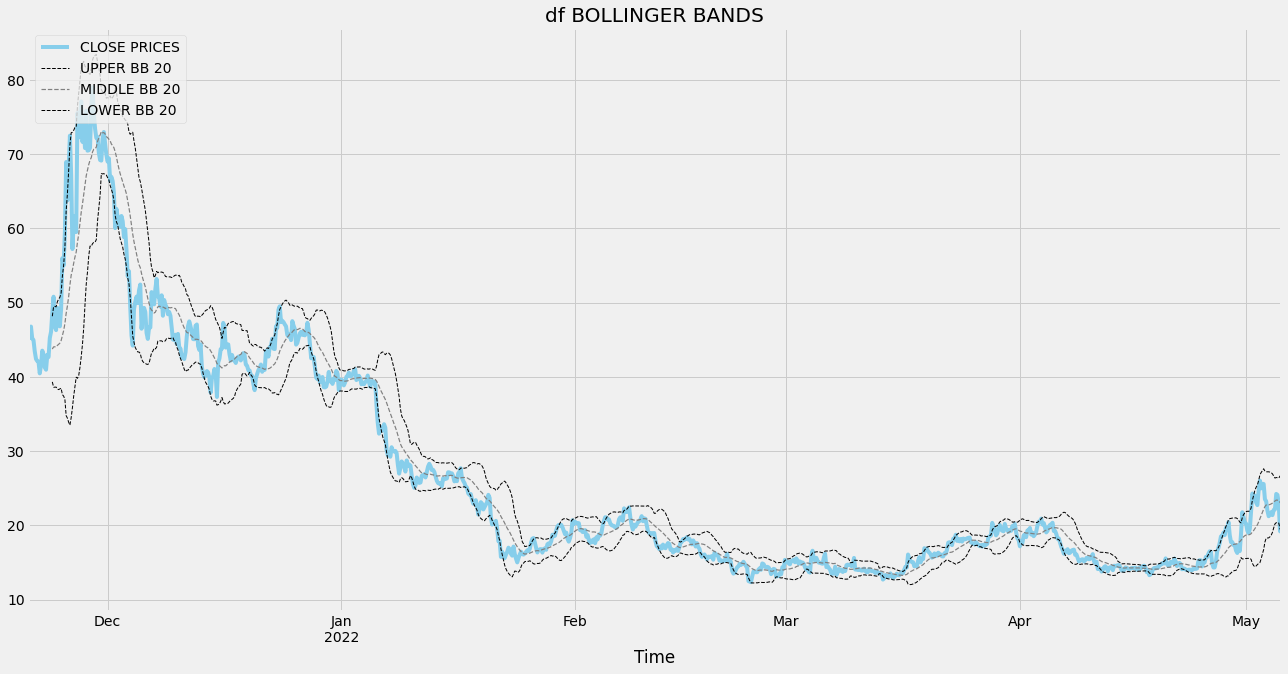

In [67]:
df['Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
df['upper_bb'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
df['sma_20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
df['lower_bb'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('df BOLLINGER BANDS')
plt.show()

In [68]:
def implement_bb_strategy(df_close, upper_bb):

    BBBi = [] #bolinger band breakout index
    BBBv = [] #bolinger band breakout value
    entries = [] #the first value that is bigger than the breakout
    entries_Index = [] #the index of entries

    entriesWITHindex = []
    
    for i in range(len(df)):
        if df_close[i] > upper_bb[i]:
            BBBi.append(df.index[i])
            BBBv.append(df_close[i])
    
    for i in range(len(BBBi)):
        for entry_value in df_close[BBBi[i]:]:
            if BBBv[i] < entry_value:
                entries.append(entry_value)
    
                entry_index=df_close.loc[df_close == entry_value].index.values[0]
                entries_Index.append(entry_index)

                entriesWITHindex.append((entry_value, entry_index))

                # print(f"breakout {BBBv[i]}, at {BBBi[i]}")
                # print(f"entry {entry_value}, at {entry_index}")

                diff =str(entry_index - BBBi[i])
                diff = int(diff.split(" ")[0])
                # print((diff))


                # remove entries that are more than 4 days apart of breakout signal
                # less than 0 is because i found a -82 days!!
                if diff > 4 or diff < 0:
                    del entries[-1]
                    del entries_Index[-1]

                break
        # print('\n')

    return BBBv, BBBi, entries, entries_Index, entriesWITHindex
      

BBBv, BBBi, entries, entries_Index, entriesWITHindex = implement_bb_strategy(df['Close'], df['upper_bb'])

In [69]:
# remove signal that are next to each other 
def remove_neighbors(entries_Index ):
    neighbors = []

    for i in range(len(entries_Index)-1):
        s=str(pd.to_datetime(entries_Index[i+1]) - pd.to_datetime(entries_Index[i]))
        s=int(s.split(" ")[0])

        if s <= 3:
            # neighbors.append(i)
            neighbors.append(entries_Index[i+1])


    for n in list(neighbors):
        # print(n)
        if n in entries_Index:
            entries_Index.remove(n)
        

    # entries = [n for n in neighbors if not determine(x)]


    # print(neighbors)
    # print(len(entries))
    print(len(entries_Index))

    return neighbors

# remove_neighbors(entries_Index)


In [70]:
# strategy1: sell after 5% profit








In [71]:

# # Volume Plot
# fig.add_trace(go.Bar(x = df['datetime'], y = df['volume'], showlegend=False), 
#               row = 2, col = 1)
import plotly.graph_objects as go

# plot the candlesticks
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df.Open, 
                                     high=df.High,
                                     low=df.Low,
                                     close=df.Close), 
                      go.Scatter(x=df.index, y=df['sma_20'], line=dict(color='orange', width=1)),
                      go.Scatter(x=df.index, y=df['upper_bb'], line=dict(color='green', width=1)),
                      go.Scatter(x=df.index, y=df['lower_bb'], line=dict(color='green', width=1))])


for b in entries_Index:
    # b is of type np_datetime64, it wont work with plotly
    # so you have to transform it into pandas datetime
    b= pd.to_datetime(b)

    fig.add_vline(x=b, line_width=1, line_dash="dash", line_color="green")


fig.update_layout(template = 'plotly_dark')
fig.layout.xaxis.rangeslider.visible = False


fig.show()

